In [3]:
from neo4j import GraphDatabase
import subprocess

uri = "neo4j+s://9131f4a0.databases.neo4j.io"
user = "neo4j"
password = "FAmuFe1S-fWnns6I4G58LBQ2wZjWRvtRMOiny51-Ufo"

driver = GraphDatabase.driver(uri, auth=(user, password))

def create_increase_decrease_relationships(driver):
    with driver.session() as session:
        session.run("""
        MATCH (a:Activity), (b:Activity)
        WHERE a.time_elapsed < b.time_elapsed AND a.total_upload < b.total_upload
        WITH a, b
        ORDER BY a.time_elapsed, b.time_elapsed
        MERGE (a)-[:INCREASED_UPLOAD_FROM]->(b)
        """)

        session.run("""
        MATCH (a:Activity), (b:Activity)
        WHERE a.time_elapsed < b.time_elapsed AND a.total_download > b.total_download
        WITH a, b
        ORDER BY a.time_elapsed, b.time_elapsed
        MERGE (a)-[:DECREASED_DOWNLOAD_FROM]->(b)
        """)

def add_network_node_and_devices(driver):
    def get_connected_devices():
        result = subprocess.run(["arp", "-a"], capture_output=True, text=True)
        if result.returncode == 0:
            devices = []
            lines = result.stdout.split('\n')
            for line in lines:
                if line:
                    parts = line.split()
                    if len(parts) > 1:
                        ip_address = parts[1].strip('()')
                        devices.append(ip_address)
            return devices
        else:
            return ["Ağa bağlı cihazlar alınamadı"]

    with driver.session() as session:
        # Eski cihaz düğümlerini ve ilişkilerini sil
        session.run("""
        MATCH (d:Device)-[r:CONNECTED_TO]->(n:Network {name: 'Local Network'})
        DETACH DELETE d, r
        """)

        # Ağ düğümünü oluştur
        session.run("""
        MERGE (n:Network {name: 'Local Network'})
        """)

        connected_devices = get_connected_devices()
        for device in connected_devices:
            # Cihaz düğümünü oluştur ve Ağ düğümüne bağla
            session.run("""
                MERGE (d:Device {ip_address: $ip_address})
                WITH d
                MATCH (n:Network {name: 'Local Network'})
                MERGE (d)-[:CONNECTED_TO]->(n)
                """,
                ip_address=device
            )

create_increase_decrease_relationships(driver)
add_network_node_and_devices(driver)
driver.close()


In [2]:
from neo4j import GraphDatabase

uri = "neo4j+s://9131f4a0.databases.neo4j.io"
user = "neo4j"
password = "FAmuFe1S-fWnns6I4G58LBQ2wZjWRvtRMOiny51-Ufo"

driver = GraphDatabase.driver(uri, auth=(user, password))

def add_network_node_and_devices(driver, connected_devices):
    with driver.session() as session:
        # Eski cihaz düğümlerini ve ilişkilerini sil
        session.run("""
        MATCH (d:Device)-[r:CONNECTED_TO]->(n:Network {name: 'Local Network'})
        DETACH DELETE d, r
        """)

        # Ağ düğümünü oluştur
        session.run("""
        MERGE (n:Network {name: 'Local Network'})
        """)

        for device, (upload, download) in connected_devices.items():
            print(f"Creating device {device} with upload {upload} and download {download}")  # Debug: Print device creation
            # Cihaz düğümünü oluştur
            session.run("""
                MERGE (d:Device {ip_address: $ip_address})
                """,
                ip_address=device
            )

            # Cihazdan Ağa ilişki oluştur
            session.run("""
                MATCH (d:Device {ip_address: $ip_address})
                MATCH (n:Network {name: 'Local Network'})
                MERGE (d)-[:CONNECTED_TO {upload: $upload, download: $download}]->(n)
                """,
                ip_address=device, upload=upload, download=download
            )

            # Ağdan Cihaza ilişki oluştur
            session.run("""
                MATCH (d:Device {ip_address: $ip_address})
                MATCH (n:Network {name: 'Local Network'})
                MERGE (n)-[:CONNECTED_TO {upload: $upload, download: $download}]->(d)
                """,
                ip_address=device, upload=upload, download=download
            )


file_path = '/Users/elkak/PycharmProjects/agProgramming/network_data.csv'  
connected_devices = get_connected_devices_from_csv(file_path)
add_network_node_and_devices(driver, connected_devices)
driver.close()


NameError: name 'get_connected_devices_from_csv' is not defined

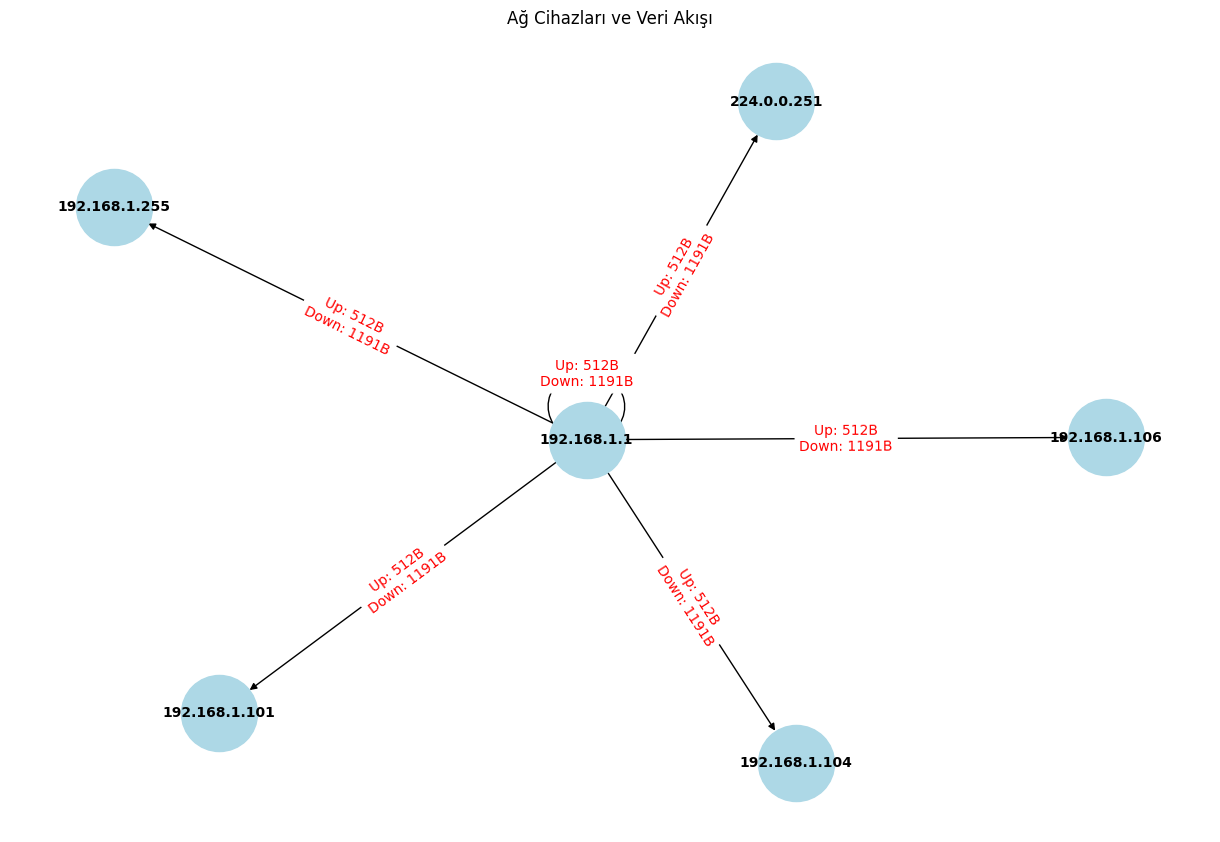

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import ast

# CSV dosyasını oku
network_data = pd.read_csv('/Users/elkak/PycharmProjects/agProgramming/network_data.csv')

# Anahtarları tırnak içine alarak veriyi temizleme fonksiyonu
def clean_device_usage(data):
    cleaned_data = []
    for item in data.split(';'):
        parts = item.split(': ')
        key = parts[0].strip()
        value = ': '.join(parts[1:]).strip()
        key = f'"{key}"'
        cleaned_data.append(f'{key}: {value}')
    return '{' + ', '.join(cleaned_data) + '}'

# Veriyi temizleme ve işleme
network_data['Bağlı Cihazlar'] = network_data['Bağlı Cihazlar'].apply(lambda x: x.split(', '))
network_data['Cihaz Veri Kullanımı'] = network_data['Cihaz Veri Kullanımı'].apply(lambda x: ast.literal_eval(clean_device_usage(x)))

# Ağ grafiğini oluşturma
G = nx.DiGraph()

# Ana cihazı ekleme
main_device = '192.168.1.1'
G.add_node(main_device)

# Bağlı cihazları ve veri akışını ekleme
for index, row in network_data.iterrows():
    for device in row['Bağlı Cihazlar']:
        G.add_node(device)
        if device in row['Cihaz Veri Kullanımı']:
            G.add_edge(main_device, device, upload=row['Cihaz Veri Kullanımı'][device]['upload'], download=row['Cihaz Veri Kullanımı'][device]['download'])

# Grafik oluşturma
pos = nx.spring_layout(G)
edges = G.edges(data=True)
edge_labels = {(u, v): f"Up: {d['upload']}B\nDown: {d['download']}B" for u, v, d in edges}

plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, font_weight='bold', arrows=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

plt.title("Ağ Cihazları ve Veri Akışı")
plt.show()


In [4]:
pip install pyvis


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 2.0 MB/s eta 0:00:00a 0:00:01m
Note: you may need to restart the kernel to use updated packages.


In [9]:
import pandas as pd
import ast
from pyvis.network import Network

# CSV dosyasını oku
network_data = pd.read_csv('/Users/elkak/PycharmProjects/agProgramming/network_data.csv')

# Anahtarları tırnak içine alarak veriyi temizleme fonksiyonu
def clean_device_usage(data):
    cleaned_data = []
    for item in data.split(';'):
        parts = item.split(': ')
        key = parts[0].strip()
        value = ': '.join(parts[1:]).strip()
        key = f'"{key}"'
        cleaned_data.append(f'{key}: {value}')
    return '{' + ', '.join(cleaned_data) + '}'

# Veriyi temizleme ve işleme
network_data['Bağlı Cihazlar'] = network_data['Bağlı Cihazlar'].apply(lambda x: x.split(', '))
network_data['Cihaz Veri Kullanımı'] = network_data['Cihaz Veri Kullanımı'].apply(lambda x: ast.literal_eval(clean_device_usage(x)))

# Ağ grafiğini oluşturma
net = Network(notebook=True, directed=True)

# Ana cihazı ekleme
main_device = '192.168.1.1'
net.add_node(main_device, label=main_device, color='red', size=30)

# Bağlı cihazları ve veri akışını ekleme
for index, row in network_data.iterrows():
    for device in row['Bağlı Cihazlar']:
        net.add_node(device, label=device, color='blue')
        if device in row['Cihaz Veri Kullanımı']:
            upload = row['Cihaz Veri Kullanımı'][device]['upload']
            download = row['Cihaz Veri Kullanımı'][device]['download']
            net.add_edge(main_device, device, title=f"Up: {upload}B\nDown: {download}B", label=f"Up: {upload}B\nDown: {download}B")

# Ağ grafiğini gösterme
net.show("network_graph.html")


network_graph.html


In [1]:
import pandas as pd
import ast
from pyvis.network import Network
import json

# CSV dosyasını oku
network_data = pd.read_csv('/Users/elkak/PycharmProjects/agProgramming/network_data.csv')

# Anahtarları tırnak içine alarak veriyi temizleme fonksiyonu
def clean_device_usage(data):
    cleaned_data = []
    for item in data.split(';'):
        parts = item.split(': ')
        key = parts[0].strip()
        value = ': '.join(parts[1:]).strip()
        key = f'"{key}"'
        cleaned_data.append(f'{key}: {value}')
    return '{' + ', '.join(cleaned_data) + '}'

# Veriyi temizleme ve işleme
network_data['Bağlı Cihazlar'] = network_data['Bağlı Cihazlar'].apply(lambda x: x.split(', '))
network_data['Cihaz Veri Kullanımı'] = network_data['Cihaz Veri Kullanımı'].apply(lambda x: ast.literal_eval(clean_device_usage(x)))

# Ağ grafiğini oluşturma
net = Network(notebook=True, directed=True)

# Ana cihazı ekleme
main_device = '192.168.1.1'
net.add_node(main_device, label=main_device, color='red', size=30)

# Bağlı cihazları ve veri akışını ekleme
for index, row in network_data.iterrows():
    for device in row['Bağlı Cihazlar']:
        net.add_node(device, label=device, color='blue')
        if device in row['Cihaz Veri Kullanımı']:
            upload = row['Cihaz Veri Kullanımı'][device]['upload']
            download = row['Cihaz Veri Kullanımı'][device]['download']
            net.add_edge(main_device, device, title=f"Up: {upload}B\nDown: {download}B", label=f"Up: {upload}B\nDown: {download}B")

# Fiziksel parametreleri ayarlama (kenar mesafesini artırma)
options = {
    "edges": {
        "smooth": {
            "type": "dynamic"
        },
        "length": 300  # Kenar uzunluğunu artırma
    },
    "physics": {
        "forceAtlas2Based": {
            "gravitationalConstant": -50,
            "centralGravity": 0.005,
            "springLength": 230,
            "springConstant": 0.18
        },
        "minVelocity": 0.75,
        "solver": "forceAtlas2Based"
    }
}
net.set_options(json.dumps(options))  # JSON string olarak geçme

# Ağ grafiğini gösterme
net.show("network_graph.html")


network_graph.html
